<a href="https://colab.research.google.com/github/Oriolrt/MVC_M2_PGM/blob/main/Guided_Exercise/1_Guided_Exercise_Pairwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Guided Exercise

This guided exercise is devoted to learn how to implement a Conditional Random Field (CRF) to solve typical image processing tasks. It is composed of two parts: first, we will see how to model a given problem using CRF. Then, we will apply available inference algorithms on PGM to evaluate their performance

In [1]:
# @title Install pylibDAI and other dependencies
#!nvidia-smi
# We install required libraries
!apt-get install libboost-dev libboost-graph-dev libboost-program-options-dev libboost-test-dev libgmp-dev cimg-dev libboost-program-options-dev
!pip install Pillow networkx
!pip install git+https://github.com/Oriolrt/pylibdai.git

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 344.1 kB/s eta 0:00:0000:0100:01
DEPRECATION: python-apt 2.4.0-ubuntu4-zorin1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-apt or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/Oriolrt/pylibdai.git to /tmp/pip-re

In [2]:
# @title
!apt update
!apt install imagemagick
!apt install pdf2svg
!apt install texlive texlive-latex-extra
!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git
%load_ext tikzmagic

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Cloning https://github.com/mkrphys/ipython-tikzmagic.git to /tmp/pip-req-build-5erkjro9
  Running command git cl

In [1]:
# @title
# We import libraries
import numpy as np
from time import time
import matplotlib.pyplot as plt


def energy(x, y, pairwise):
    # x is unaries
    # y is a labeling
    n_states = pairwise.shape[0]
    ## unary features:
    gx, gy = np.ogrid[:x.shape[0], :x.shape[1]]
    selected_unaries = x[gx, gy, y.astype(int)]
    unaries_acc = np.sum(x[gx, gy, y.astype(int)])
    unaries_acc = np.bincount(y.astype(int).ravel(), selected_unaries.ravel(),
                              minlength=n_states)

    ##accumulated pairwise
    #make one hot encoding
    labels = np.zeros((y.shape[0], y.shape[1], n_states),
                      dtype=np.int32)
    gx, gy = np.ogrid[:y.shape[0], :y.shape[1]]
    labels[gx, gy, y.astype(int)] = 1
    # vertical edges
    vert = np.dot(labels[1:, :, :].reshape(-1, n_states).T,
                  labels[:-1, :, :].reshape(-1, n_states))
    # horizontal edges
    horz = np.dot(labels[:, 1:, :].reshape(-1, n_states).T,
                  labels[:, :-1, :].reshape(-1, n_states))
    pw = vert + horz
    pw = pw + pw.T - np.diag(np.diag(pw))
    energy = np.dot(np.tril(pw).ravel(), pairwise.ravel()) + unaries_acc.sum()
    return energy


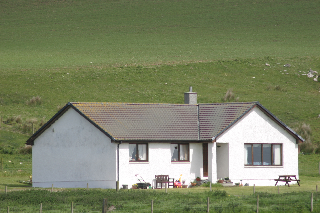

In [2]:
from PIL import Image

image = Image.open('3_12_s.bmp')
image

# Exercise 1
Cluster image pixels according their colors using a Gaussian Mixture Model. Fix parameters $k$ and $smooth\_term$ below to play with the output of inference algorithms (Exercise 2).




In [34]:
# Gaussian Mixture Model libraries
from sklearn import mixture
from numpy import asarray

k=12
smooth_term = [0.0, 0.4]


potential=asarray(image)
midaOriginal = potential.shape
newShape=(*midaOriginal[:2],k)
print(f"Size of the original image: {potential.shape}")
potential=potential.reshape( (midaOriginal[0]*midaOriginal[1], midaOriginal[2]))
print(f"Size of the Unary potentials: {potential.shape}")

gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(potential)

mean_color = gmm.means_.astype(int)

y = gmm.predict(potential)
segmented_image = mean_color[y]
segmented_image = segmented_image.reshape(midaOriginal)

# Get the probabilities (responsibilities) for each component
probs = gmm.predict_proba(potential) 

# Compute the unary potentials as negative log probabilities
unary_term = -np.log(probs + 1e-10)

Size of the original image: (213, 320, 3)
Size of the Unary potentials: (68160, 3)


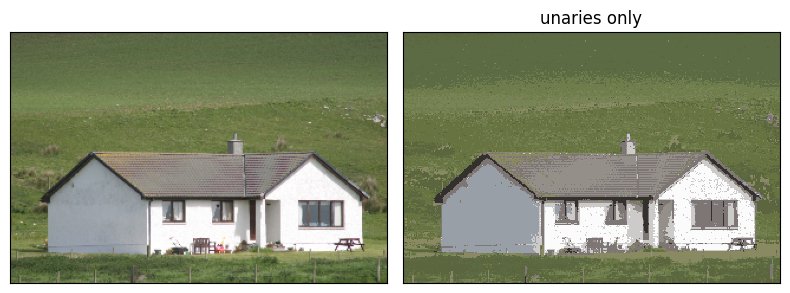

In [35]:
fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("unaries only")
axes[1].matshow(segmented_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

## Building the Model

A key step is the construction of the factor graph representation that will represent the dependencies between random variables (represented as nodes in the graph).

As we want represent each pixel as a random variable which is 4-connected to adjacent pixels (a regular grid), we must define a graph that takes into account this topology. A candidate model is the factor graph shown below. The blue nodes, $x$, represent the observations (image) and white nodes, $y$, represent the latent (or hidden) variables.



In [26]:
# @title
%%tikz -l arrows,shapes,fit,positioning,calc,shadows,matrix  --scale 2 --size 300,300 -f svg
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 10 pt, drop shadow, fill=white!20] (yp) {$y_p$};
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 10 pt, drop shadow, fill=white!20,right=of yp] (yq) {$y_q$};
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 10 pt, drop shadow, fill=white!20,below=of yp,fill=cyan!20] (xp) {$x_p$} edge node[draw, fill           = black,   text           = red,  drop shadow,midway,label=left:$f_c$] {} (yp) ;
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 10 pt, drop shadow, fill=white!20,below=of yq,fill=cyan!20] (xq) {$x_q$} edge node[draw, fill           = black,   text           = red,  drop shadow,midway,label=right:$f_c$] {} (yq);
\draw (yp) -- (yq) node[draw, fill           = black,   text           = red,  drop shadow,midway,label=$f_{p,q}$] (f) {};
\node[fit=(yp) (yq) (xp) (xq) (f),draw,rounded corners,label=above right:$pq\in \mathcal{E}$,inner sep=4mm] (q) {};


SyntaxError: unexpected character after line continuation character (453189076.py, line 3)

We will first define the function __BuildPairwiseFactorGraph__ that given an image will return  a list of __factors__. Each factor is define by a tuple of the form:  *( m , f )* , where *m* is a list of variable indices and *f* corresponds to a n-dimensional array  with the factor values.

This function also returns, as second element, the energy of the factor graph.

In [36]:
def BuildPairwiseFactorGraph( image : Image, num_states : int = 1, theta : list = [0.0, 2.0], obs_probs : np.array  = None ):
  potential=asarray(image)
  midaOriginal = potential.shape
  nFils=midaOriginal[0]
  nCols=midaOriginal[1]
  nNodes = nFils*nCols

  # Building pairwise factors between latent variables
  down_edges = [(i,i+1) for i in range(nNodes) if (i+1) % nFils != 0 ]
  right_edges = [(i,i+nFils) for i in range(nNodes-nFils) ]

  adj = down_edges + right_edges

  # build edges for max product inference:
  inds = np.arange( nNodes).reshape(midaOriginal[:2] ).astype(np.int64)

  # In case there are observations initialise the unary factors with the una potentials
  if obs_probs is not None:
    # unary factors
    unary_factors = [([m], p) for m, p in zip(inds.reshape(-1), obs_probs)]

  energy = theta[0]*np.eye(num_states) +theta[1]*(np.ones(num_states)-np.eye(num_states))
  pairwise_exp = np.exp( -energy )
  pairwise_factors = [(m, pairwise_exp) for m in adj]

  # We return the factor graph (as list of factors) and the energy
  return unary_factors + pairwise_factors, -energy

In [39]:
factor_list, pairwise = BuildPairwiseFactorGraph( image, num_states=k , obs_probs=probs,theta=smooth_term )

# Exercise 2
Play with the parameters in "props" (below) the number of Gaussian mixture components ($k$) and the smoothing parameters theta of the pairwise factors.
Consider also to use different inference methods as shown in the cells below

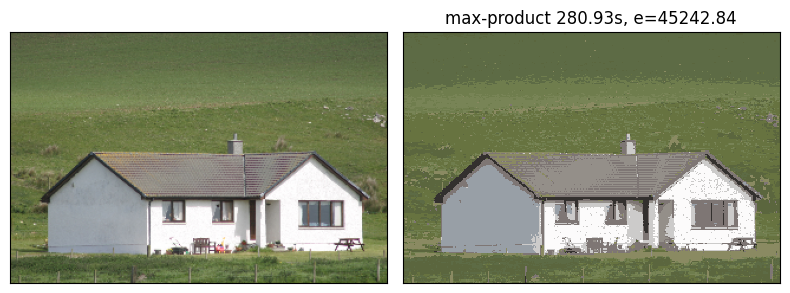

In [38]:
#TODO:
# Play with the parameters in "props" (below) the number of Gaussian mixture components (k) and the smoothing parameters theta of the pairwise factors
# Consider also to use different inference methods as shown in the cells below
from dai import dai

props = {'inference': 'MAXPROD', 'updates': 'SEQRND', 'tol': '1e-6', 'maxiter': '100', 'logdomain': '0','damping':0.1}
start = time()
qv, qf,  max_product = dai(factor_list, method= 'BP', props=props,with_beliefs=True)
time_maxprod = time() - start
max_product_image = mean_color[max_product.astype(int)]
max_product_image = max_product_image.reshape(midaOriginal)
energy_max_prod = energy(np.array([ x.tolist() for (m,x) in qv]).reshape(newShape) , max_product.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("max-product %.2fs, e=%.2f"% (time_maxprod, energy_max_prod))
axes[1].matshow(max_product_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

In [ ]:
props = {'inference': 'SUMPROD', 'updates': 'SEQRND', 'tol': '1e-6', 'maxiter': '100', 'logdomain': '0','damping':0.1}
start = time()
qv, qf, bp = dai(factor_list, method='BP', props=props,with_beliefs=True)
time_bp = time() - start
bp_image = mean_color[bp.astype(int)]
bp_image = bp_image.reshape(midaOriginal)
energy_bp = energy(unary_term.reshape(newShape), bp.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("Belief Propagation %.2fs, e=%.2f"% (time_bp, energy_bp))
axes[1].matshow(bp_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

Starting GIBBS[maxiter=100,maxtime=inf,restart=100,burnin=0,verbose=1]...

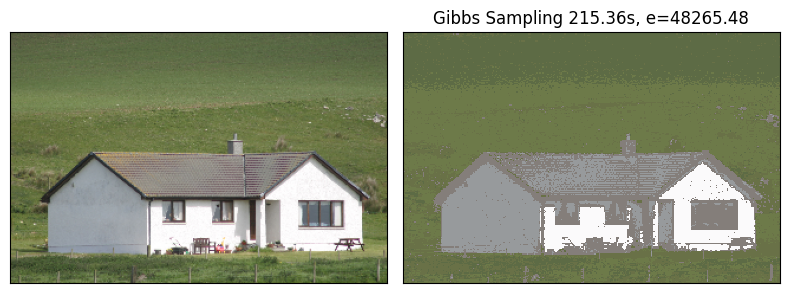

In [33]:
props = {'inference': 'SUMPROD', 'updates': 'SEQRND', 'tol': '1e-2', 'maxiter': '100', 'logdomain': '0','burnin':0,'verbose':1 }
start = time()
qv, qf, gibbs = dai(factor_list, method='GIBBS', props=props,with_beliefs=True)
time_gibbs = time() - start
gibbs_image = mean_color[gibbs.astype(int)]
gibbs_image = gibbs_image.reshape(midaOriginal)
energy_gibbs =   energy(np.array([ x.tolist() for (m,x) in qv]).reshape(newShape) , gibbs.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("Gibbs Sampling %.2fs, e=%.2f"% (time_gibbs, energy_gibbs))
axes[1].matshow(gibbs_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()